# Recreating @idatadrew's implementation which can be found [here](https://public.tableau.com/views/NHL-ChangeinAverageAttendanceperGame/NHL-ChangeinAverageAttendanceperGame?:embed=y&:display_count=yes&publish=yes&:toolbar=no&:showVizHome=no).

## What is the % change in average attendance per game for NHL teams compared to the 2000-01 season?

Average attendance per game has steadily increased **compared to the 2000-01 season** for most teams. Chiago Blackhawks have seen the most <font color=blue>**positive % change**</font>, whereas Colorado Avalanche have seen the most <font color=red>**negative % change**</font>.

In [1]:
import math
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
pd.options.mode.chained_assignment = None #surpress is copy warning

In [2]:
df = pd.read_csv('./NHL Attendance.csv')
df.columns

Index(['SEASON', 'RANK', 'TEAM', 'HOME GAMES', ' HOME ATTENDANCE ',
       'ROAD GAMES', ' ROAD ATTENDANCE ', 'TOTAL GAMES', ' TOTAL ATTENDANCE '],
      dtype='object')

In [3]:
df = df.query('TEAM != "Vegas"')
print(df.groupby('TEAM')['SEASON'].count())

TEAM
Anaheim         17
Arizona         17
Boston          17
Buffalo         17
Calgary         17
Carolina        17
Chicago         17
Colorado        17
Columbus        17
Dallas          17
Detroit         17
Edmonton        17
Florida         17
Los Angeles     17
Minnesota       17
Montreal        17
NY Islanders    17
NY Rangers      17
Nashville       17
New Jersey      17
Ottawa          17
Philadelphia    17
Pittsburgh      17
San Jose        17
St. Louis       17
Tampa Bay       17
Toronto         17
Vancouver       17
Washington      17
Winnipeg        17
Name: SEASON, dtype: int64


In [4]:
def clean_numeric_column(df, column_name):
    series = df[column_name].str.strip()
    series = series.str.replace(',', '')
    series = pd.to_numeric(series)
    df[column_name] = series
    return df

data = df[['TEAM', 'SEASON', ' TOTAL ATTENDANCE ', 'TOTAL GAMES']]
data = clean_numeric_column(data, ' TOTAL ATTENDANCE ')

def calculate_percent_change(current_season, previous_season):
    if (math.isnan(current_season) or math.isnan(previous_season)):
        return 0
    
    if (current_season > previous_season):
        return previous_season / current_season
    
    if (previous_season > current_season):
        return -(current_season / previous_season)
    

data['AVERAGE ATTENDANCE PER GAME'] = data[' TOTAL ATTENDANCE '] / data['TOTAL GAMES']
data['PREVIOUS AVERAGE ATTENDANCE PER GAME'] = data['AVERAGE ATTENDANCE PER GAME'].shift(1)

data['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'] = data.apply(lambda row: 
    calculate_percent_change(
        row['AVERAGE ATTENDANCE PER GAME'], 
        row['PREVIOUS AVERAGE ATTENDANCE PER GAME']
    ),
    axis = 1 #applies lambda to row
)
data = data.query('SEASON != "2000-01"')
piviot_table = pd.pivot_table(data, values='PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME', index='TEAM',  columns='SEASON')


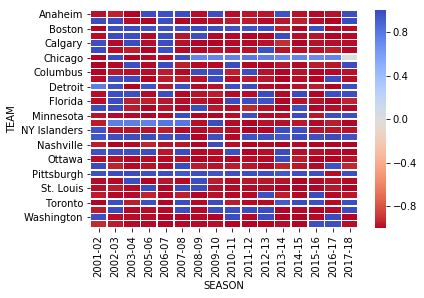

In [5]:
ax = sns.heatmap(piviot_table, linewidth=0.5, cmap="coolwarm_r")
plt.show()